# Example 4 - constant-velocity 2D motion tracking

Here, we will follow a series of examples taken from [[4]](#sarkka) for tracking vehicle motion in 2D.

![2D motion](./car2D.png)

Assume that a car is represented by a point mass at its centre $(x_1, x_2),$ and moves in the $x_1$-$x_2$ plane subject to noisy forces $g_1(t),$ $g_2(t).$ Then, according to Newton's law of motion, $F=ma,$ we can simply write $g_i(t)=ma_i(t),$ where $a_i = \ddot{x_i}.$ Now, since $g_i(t)$ are badly known, or unknown, we can model $g_i(t)/m$ as random processes, and more precisely as independent, white noise (Wiener) processes. We thus obtain the 2nd order system

$$
\begin{align} 
   \ddot{x}_1 &= w_1(t), \\
   \ddot{x}_2 &= w_2(t),
\end{align}
$$

where $w_i \sim \mathcal{N} ( 0, \sigma^2_{w_{i}} ).$ Defining the velocities, $x_3 = \dot{x}_1,$ and $x_4 = \dot{x}_2,$ we can write this as a first order system,

$$ \frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t} = F \mathbf{x} + L \mathbf{w} , \quad \mathbf{x}(0) = \mathbf{x}_0,$$ 

where 

$$ \mathbf{x}=\begin{bmatrix}x_1\\ x_2 \\ x_3 \\ x_4 \end{bmatrix},\quad
   F=\begin{bmatrix} 0 & 0 & 1 & 0\\  0 & 0 & 0 & 1 \\  0 & 0 & 0 & 0 \\  0 & 0 & 0 & 0  \end{bmatrix},\quad 
   L=\begin{bmatrix} 0 & 0 \\  0 & 0 \\ 1 & 0 \\ 0 &1  \end{bmatrix},\quad
   \mathbf{w}= \begin{bmatrix} w_1  \\ w_2 \end{bmatrix}.
$$

More generally, we can consider a $d$-dimensional ($d=1,2,3),$ continuous-time, constant-velocity model for the motion of an object in space,

$$
\frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t} = \begin{bmatrix}0 & I\\  0 & 0 \end{bmatrix}
    \mathbf{x} + \begin{bmatrix}0\\  I  \end{bmatrix} \mathbf{w} ,
$$

which just denotes that the derivaitve of the  position is the velocity, and that the derivative of the velocity is the process noise. We can now proceed to discretizing this system, as derived in [[4]](#sarkka), to obtain

$$
\mathbf{x}_{k+1 } = F  \mathbf{x}_{k} + \mathbf{q}_{k},
$$

where 

$$
 F = \begin{bmatrix} 1 & 0 & \Delta t & 0\\  0 & 1 & 0 & \Delta t \\  0 & 0 & 1 & 0 \\  0 & 0 & 0 & 1  \end{bmatrix},
$$

and $ \mathbf{q}_{k}$ is a discrete-time, Gaussian noise process with mean zero and covariance

$$
 Q = \begin{bmatrix} q_1 \Delta t^3 / 3  & 0 & q_1 \Delta t^2 / 2  & 0
      \\  0 & q_2 \Delta t^3 / 3 & 0 & q_2 \Delta t^2 / 2 
      \\  q_1 \Delta t^2 / 2  & 0 & q_1 \Delta t  & 0 
      \\  0 &  q_2 \Delta t^2 / 2  & 0 &  q_2 \Delta t \end{bmatrix}.
$$

## State-space model

Assuming the above dynamics, and adding a noisy position measurement model, we obtain the linear state-space model

$$
\begin{align} 
  \mathbf{x}_{k+1 } &= F  \mathbf{x}_{k} + \mathbf{q}_{k}, \quad \mathbf{q}_{k} \sim \mathcal{N} (0, Q), \\
   \mathbf{y}_{k+1 } &= H \mathbf{x}_{k} + \mathbf{r}_{k}, \quad \mathbf{r}_{k} \sim \mathcal{N} (0, R),
\end{align}
$$

with

$$
  H = \begin{bmatrix} 1 & 0 & 0 & 0\\  0 & 1 & 0 & 0 \end{bmatrix}, \quad
  R = \begin{bmatrix} \sigma_1^2 & 0 \\  0 & \sigma_2^2  \end{bmatrix}  .
$$

We are now ready to simulate the Kalman filter.

1. definition of all parameters
2. initilization of all matrices
3. simulation and generate noisy measurements - plot
4. Kalman filter
5. Kalman smoother

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
# we use Sarkka's utilities to streamline a bit...
from common_utilities import generate_ssm, RandomState, rmse, plot_car_trajectory
# initialize
q = 1.    # process noise
dt = 0.1  # time step
s = 0.5   # measurement noise

M = 4  # State dimension
N = 2  # Observation dimension

A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

R = np.array([[s ** 2, 0],
              [0, s ** 2]])

x_0 = np.array([0., 0., 1., -1.])

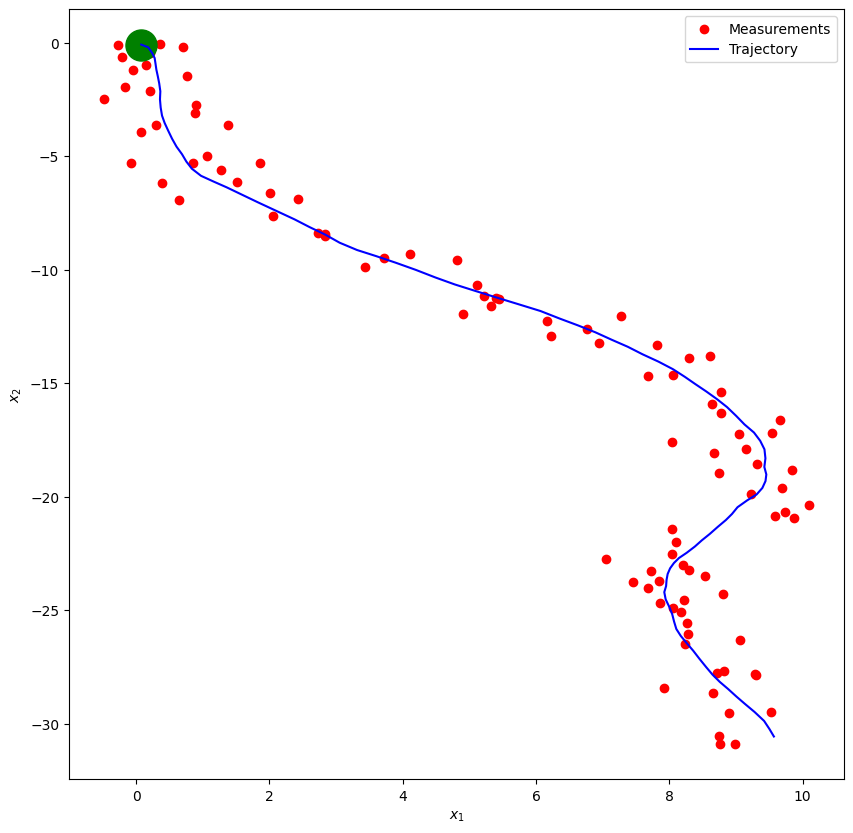

In [5]:
# Simulate trajectory and noisy measurements
random_state = RandomState(6)
steps = 100

states, observations = generate_ssm(x_0, A, Q, H, R, steps, random_state)

plot_car_trajectory(observations, states, "Trajectory")

## Kalman filter

In [7]:
def kalman_filter(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    for i in range(steps):
        y = observations[i]
        m = A @ m
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        
        m = m + K @ (y - H @ m)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

RAW RMSE: 0.7131995943918173
KF RMSE: 0.3746597043548562


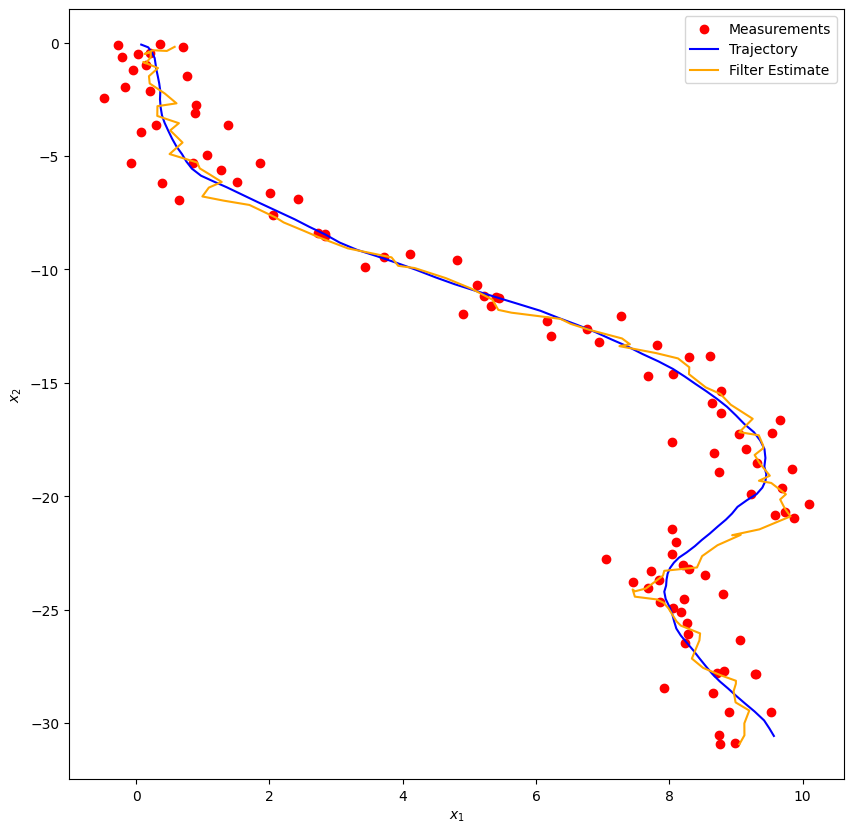

In [10]:
m_0 = x_0
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

kf_m, kf_P = kalman_filter(m_0, P_0, A, Q, H, R, observations)

plot_car_trajectory(observations, states, "Trajectory", kf_m, "Filter Estimate")

rmse_raw = rmse(states[:, :2], observations)
rmse_kf = rmse(kf_m[:, :2], states[:, :2])
print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")

## Kalman smoother

THe RTS smoother requires a forward run of the Kalman filter that provides the state and the covariance matrix, for all time steps.


In [11]:
def rts_smoother(kf_m, kf_P, A, Q):
    steps, M = kf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = kf_m[-1]
    P = kf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = kf_m[i]
        filtered_P = kf_P[i]
        
        mp = A @ filtered_m
        Pp = A @ filtered_P @ A.T + Q

        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, A @ filtered_P, assume_a="pos").T 

        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P

RAW RMSE: 0.7131995943918173
KF RMSE: 0.3746597043548562
RTS RMSE: 0.1857332232186917


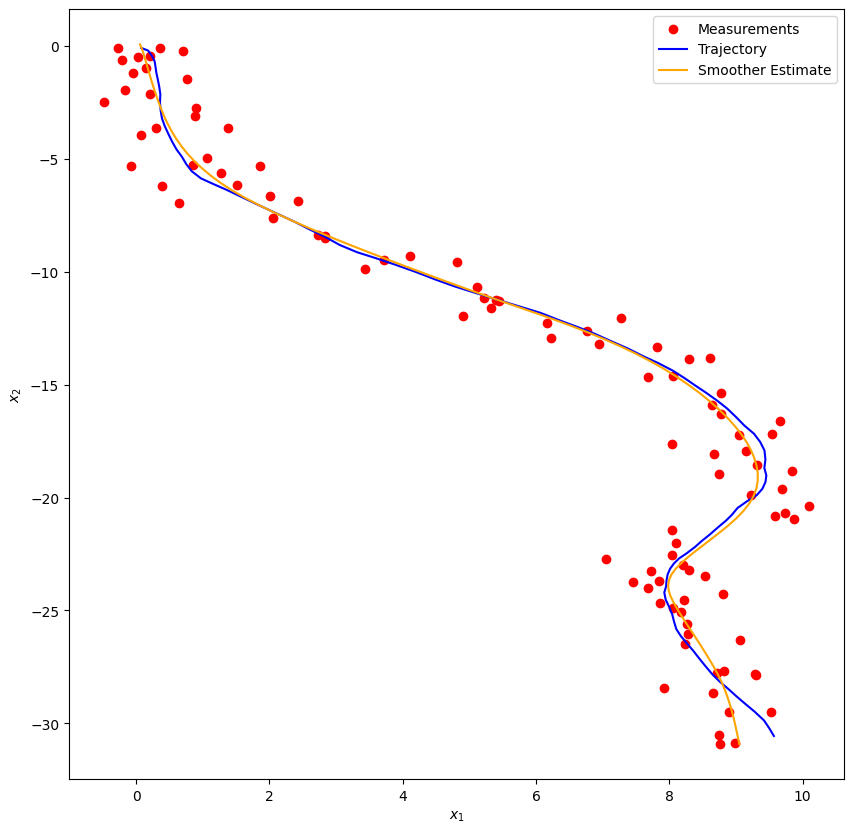

In [12]:
rts_m, rts_P = rts_smoother(kf_m, kf_P, A, Q)

plot_car_trajectory(observations, states, "Trajectory", rts_m, "Smoother Estimate")

rmse_rts = rmse(states[:, :2], rts_m[:, :2])

print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")
print(f"RTS RMSE: {rmse_rts}")

## Conclusions on Kalman Filters

- workhorse for all linear, Gaussian problems
- cases covered here:
  - track a constant
  - track a random walk
  - movement tracking: scalar consatnt velocity, 2D and 3D tracking
- 2 basic philosophies:
  1. use a KF classs
  2. include KF code each time
  3. use KF module/function
- **Choice:** I prefer (2). Since the KF is coded in only 5 lines, there is no real need for a class and the resulting code remains very readable
- Process noise  modelling, to design the matrix $Q,$ is a complex subject. See [Saho](https://www.intechopen.com/chapters/57673) and references therein.

## References

1. <a name="LSZ"></a> K. Law, A Stuart, K. Zygalakis. *Data Assimilation. A Mathematical Introduction.* Springer. 2015.
2. <a name="asch1"></a> M. Asch, M. Bocquet, M. Nodet. *Data Assimilation: Methods, Algorithms and Applications.* SIAM. 2016.
3. <a name="asch2"></a> M. Asch. *A Toobox for Digital Twins. From Model-Based to Data-Driven.* SIAM. 2022
4. <a name="sarkka"></a>  S. Sarkka, L. Svensson. *Bayesian Filtering and Smoothing,* 2nd ed., Cambridge University Press. 2023.